In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import accuracy_score
import re
import random
import gc
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [4]:
print('start reading...')
prefix = "/Users/isabelniu/Documents/HKUST-20Spring/ML/Project/CompleteDataSet/"
train = pd.read_csv(prefix + 'FinalEncodedTrain.csv')
test = pd.read_csv(prefix + "FinalEncodedTest.csv")
print('done reading')

start reading...
done reading


In [5]:
train=train.drop(train.columns[0],1)
test=test.drop(test.columns[0],1)

In [6]:
print(train.shape,test.shape)

(7377418, 35) (2556790, 35)


In [21]:
test.dtypes

artist_composer               int64
artist_composer_lyricist      int64
artist_count                  int64
artist_name                   int64
bd                            int64
city                          int64
composer                      int64
composer_count                int64
count_artist_played           int64
count_song_played             int64
expiration_date               int64
expiration_month              int64
expiration_year               int64
gender                        int64
genre_ids                     int64
genre_ids_count               int64
id                          float64
is_featured                   int64
language                    float64
lyricist                      int64
lyricists_count               int64
membership_days               int64
msno                          int64
registered_via                int64
registration_date             int64
registration_month            int64
registration_year             int64
smaller_song                

In [8]:
# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(train.drop(['target'],1), train.target, test_size=0.2)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)

In [9]:
gc.collect()

30

In [10]:
del X_train_all
del y_train_all
gc.collect()

20

In [11]:
# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [12]:
# Base line model
from sklearn.metrics import accuracy_score
m = LogisticRegression()
m.fit(X_train_sampled, y_train_sampled )
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')


Mean accuracy score validation: 0.59


In [13]:
#determine feature importance

In [14]:
def mod_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':np.abs(m.coef_[0])}
                       ).sort_values('imp', ascending=False)

fi = mod_feat_importance(m, X_train_sampled ); fi[:10]

,cols,imp
33,source_type,0.077998
32,source_system_tab,0.047393
31,source_screen_name,0.021554
11,expiration_month,0.011216
7,composer_count,0.011143
19,lyricists_count,0.006779
22,registered_via,0.006311
13,gender,0.005171
24,registration_month,0.002165
28,song_lang_boolean,0.001926


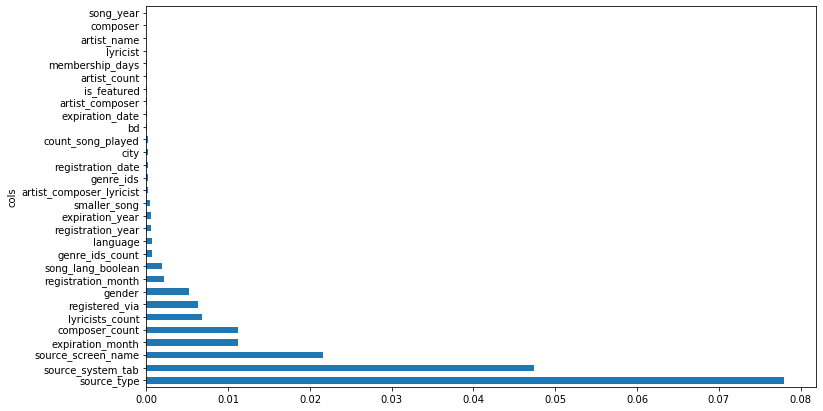

In [15]:
def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [20]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

10

In [22]:
X_train_sampled = X_train_sampled[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]
X_train = X_train[to_keep]

In [23]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', LogisticRegression())]) # Estimator: ML algorithm

grid_params = dict(clf__penalty=['l1', 'l2'],
                  clf__C = [.3,.5,.7,1])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.5957'

In [24]:
# To fit with with best hyperparameters 
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=0.7, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
# Fitting best model
m = LogisticRegression(C=0.7,penalty='l1', n_jobs=-1)
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.597


In [26]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.596


In [27]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.60732732 0.58807971]
recall: [0.53189676 0.66023993]
fscore: [0.56711483 0.62207418]
support: [733272 742212]


Confusion matrix, without normalization
[[390025 343247]
 [252174 490038]]
Normalized confusion matrix
[[0.53 0.47]
 [0.34 0.66]]


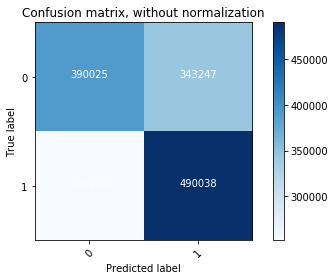

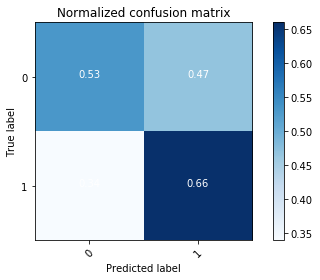

In [28]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

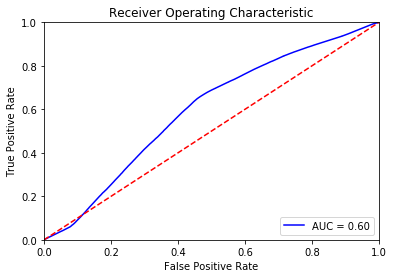

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
